# Dataset

```
MLPC2025_dataset/
├──── audio/
├──── audio_features/
├──── metadata.csv
├──── metadata_keywords_embeddings.npz
├──── metadata_title_embeddings.npz
├──── annotations.csv
├──── annotations_text_embeddings.npz
└── MLPC2025_Dataset.ipynb
```

## Data Exploration

In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_dataset"

### Metadata

In [3]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))

print(f"Metadata: {metadata.shape}")
print(metadata.columns.tolist())

Metadata: (9026, 12)
['filename', 'keywords', 'freesound_id', 'sound_link', 'manufacturer', 'license', 'title', 'description', 'num_downloads', 'geotag', 'start_time_s', 'end_time_s']


### Metadata Embeddings

In [4]:
# Load metadata embeddings
title_embeddings = np.load(os.path.join(DATA_DIR, "metadata_title_embeddings.npz"))["embeddings"]
keywords_embeddings = np.load(os.path.join(DATA_DIR, "metadata_keywords_embeddings.npz"))["embeddings"]

print(f"Metadata Title Embeddings:    {title_embeddings.shape}")
print(f"Metadata Keywords Embeddings: {keywords_embeddings.shape}")

Metadata Title Embeddings:    (9026, 1024)
Metadata Keywords Embeddings: (9026, 1024)


### Annotations

In [5]:
# Load annotations 
annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))

print(f"Annotations: {annotations.shape}")
print(annotations.columns.tolist())

Annotations: (35826, 7)
['task_id', 'filename', 'annotator', 'text', 'onset', 'offset', 'filename_unsafe']


### Annotations Embeddings

In [6]:
# Load annotations embeddings
annotations_embeddings = np.load(os.path.join(DATA_DIR, "annotations_text_embeddings.npz"))["embeddings"]
print(f"Annotations Embeddings:    {annotations_embeddings.shape}")

Annotations Embeddings:    (35826, 1024)


### Audio Features

In [7]:
# Load audio features
audio_features_dir = f"{DATA_DIR}/audio_features"
audio_feature_filename = metadata.loc[0, "filename"].replace("mp3", "npz")
audio_features = np.load(os.path.join(audio_features_dir, audio_feature_filename))

# Print individual audio feature shapes
max_key_len = len(max(audio_features.keys()))
for key in audio_features.keys():
    print(f"Audio feature[{key}]:{' ' * (max_key_len - len(key))} (time, n_features) {audio_features[key].shape}")

# Concatenate all audio features along axis=1 (feature dimension)
all_audio_features = np.hstack([audio_features[k] for k in audio_features.keys()])

# Verify the combined audio feature shape
print(f"\nAudio feature(combined):{' ' * (max_key_len - len('combined'))} (time, n_features) {all_audio_features.shape}")

Audio feature[embeddings]:       (time, n_features) (233, 768)
Audio feature[melspectrogram]:   (time, n_features) (233, 64)
Audio feature[mfcc]:             (time, n_features) (233, 32)
Audio feature[mfcc_delta]:       (time, n_features) (233, 32)
Audio feature[mfcc_delta2]:      (time, n_features) (233, 32)
Audio feature[flatness]:         (time, n_features) (233, 1)
Audio feature[centroid]:         (time, n_features) (233, 1)
Audio feature[flux]:             (time, n_features) (233, 1)
Audio feature[energy]:           (time, n_features) (233, 1)
Audio feature[power]:            (time, n_features) (233, 1)
Audio feature[bandwidth]:        (time, n_features) (233, 1)
Audio feature[contrast]:         (time, n_features) (233, 7)
Audio feature[zerocrossingrate]: (time, n_features) (233, 1)

Audio feature(combined):         (time, n_features) (233, 942)


## Dataset Basic Metrics:

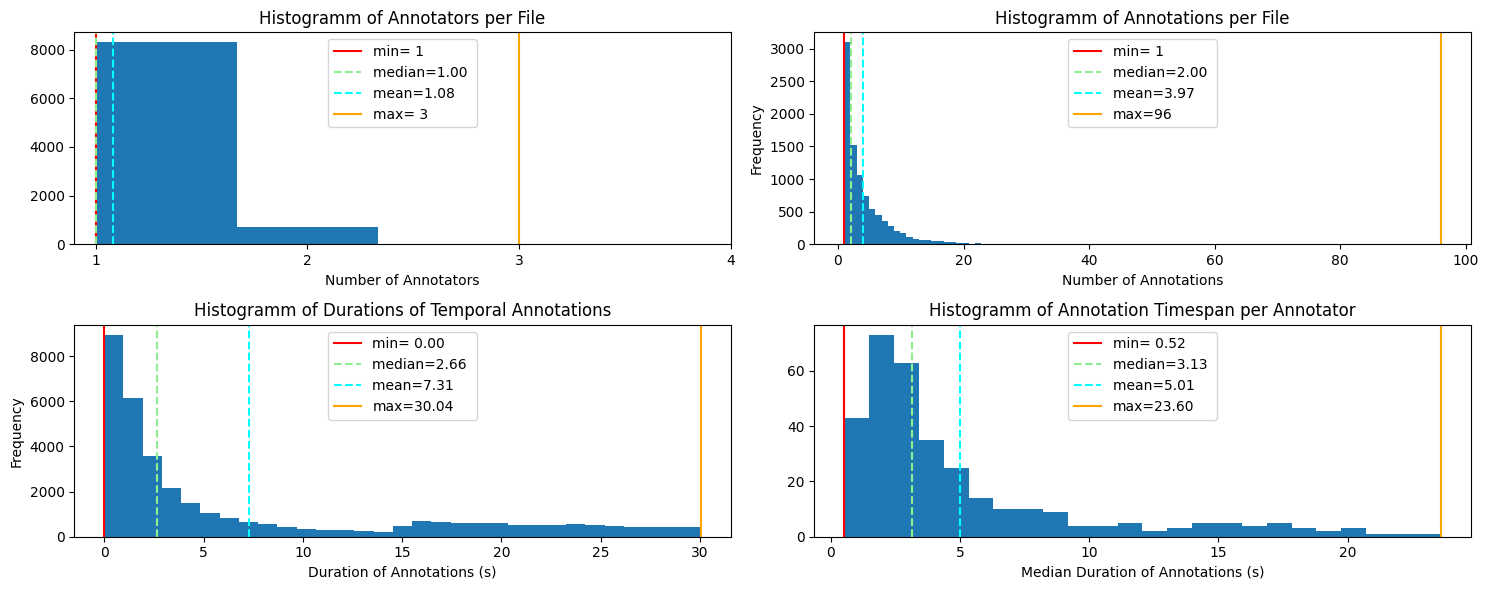

In [8]:
# Visualize Dataset Basic Metrics
plt.figure(figsize=(15, 6))

# Histogramm of annotators per file
annotators_per_file = annotations.groupby('filename')['annotator'].nunique()
plt.subplot(2, 2, 1)
plt.title("Histogramm of Annotators per File")
plt.hist(x=annotators_per_file, bins=annotators_per_file.max())
plt.axvline(x=annotators_per_file.min(), color='red', linestyle='-', label=f'min={annotators_per_file.min():2}')
plt.axvline(x=annotators_per_file.median(), color='lightgreen', linestyle='--', label=f'median={annotators_per_file.median():<5.2f}')
plt.axvline(x=annotators_per_file.mean(), color='cyan', linestyle='--', label=f'mean={annotators_per_file.mean():<5.2f}')
plt.axvline(x=annotators_per_file.max(), color='orange', linestyle='-', label=f'max={annotators_per_file.max():2}')
plt.xlabel("Number of Annotators")
plt.xticks([i+1 for i in range(annotators_per_file.max() + 1)])
plt.legend(loc='upper center')

# Histogramm of annotations per file
annotations_per_file = annotations.groupby('filename')['text'].size()
plt.subplot(2, 2, 2)
plt.title("Histogramm of Annotations per File")
plt.hist(x=annotations_per_file, bins=annotations_per_file.max())
plt.axvline(x=annotations_per_file.min(), color='red', linestyle='-', label=f'min={annotations_per_file.min():2}')
plt.axvline(x=annotations_per_file.median(), color='lightgreen', linestyle='--', label=f'median={annotations_per_file.median():<5.2f}')
plt.axvline(x=annotations_per_file.mean(), color='cyan', linestyle='--', label=f'mean={annotations_per_file.mean():<5.2f}')
plt.axvline(x=annotations_per_file.max(), color='orange',linestyle='-', label=f'max={annotations_per_file.max():2}')
plt.xlabel("Number of Annotations")
plt.ylabel("Frequency")
plt.legend(loc='upper center')

# Histogramm of durations of temporal annotations
annotations['duration'] = annotations['offset'] - annotations['onset']
plt.subplot(2, 2, 3)
plt.title("Histogramm of Durations of Temporal Annotations")
plt.hist(x=annotations['duration'], bins=int(annotations['duration'].max() + 1))
plt.axvline(x=annotations['duration'].min(), color='red', linestyle='-', label=f'min={annotations['duration'].min():5.2f}')
plt.axvline(x=annotations['duration'].median(), color='lightgreen', linestyle='--', label=f'median={annotations['duration'].median():<5.2f}')
plt.axvline(x=annotations['duration'].mean(), color='cyan', linestyle='--', label=f'mean={annotations['duration'].mean():<5.2f}')
plt.axvline(x=annotations['duration'].max(), color='orange', linestyle='-', label=f'max={annotations['duration'].max():5.2f}')
plt.xlabel("Duration of Annotations (s)")
plt.ylabel("Frequency")
plt.legend(loc='upper center')

# Histogramm of Annotation Timespan per Annotator
median_duration_per_annotator = annotations.groupby('annotator')['duration'].median()
plt.subplot(2, 2, 4)
plt.title("Histogramm of Annotation Timespan per Annotator")
plt.hist(x=median_duration_per_annotator, bins=int(median_duration_per_annotator.max() + 1))
plt.axvline(x=median_duration_per_annotator.min(), color='red', linestyle='-', label=f'min={median_duration_per_annotator.min():5.2f}')
plt.axvline(x=median_duration_per_annotator.median(), color='lightgreen', linestyle='--', label=f'median={median_duration_per_annotator.median():<5.2f}')
plt.axvline(x=median_duration_per_annotator.mean(), color='cyan', linestyle='--', label=f'mean={median_duration_per_annotator.mean():<5.2f}')
plt.axvline(x=median_duration_per_annotator.max(), color='orange', linestyle='-', label=f'max={median_duration_per_annotator.max():5.2f}')
plt.xlabel("Median Duration of Annotations (s)")
plt.legend(loc='upper center')

plt.tight_layout()
plt.show()

## Multiple Annotation Analysis:

In [9]:
# Calculate basic stats
annotator_counts = annotations.groupby('filename')['annotator'].nunique()
single_idx = annotator_counts[annotator_counts < 2].index
multi_idx = annotator_counts[annotator_counts >= 2].index

# Print shortened report
print("Multiple Annotation Analysis:")
print("="*80)
print(f"{'Number of total files:':<30} {len(annotator_counts)}")
print(f"{'Number of total annotators:':<30} {annotations['annotator'].nunique()}")
print(f"{'Number of total annotations:':<30} {len(annotations)}")

print("\nAnalysis of files with multiple annotators (≥2):")
print("-"*80)
print(f"{'Number of files:':<30} {len(multi_idx)}")
print(f"{'Total annotations:':<30} {len(annotations[annotations['filename'].isin(multi_idx)])}")

print("\nAnalysis of files with single annotator (<2):")
print("-"*80)
print(f"{'Number of files:':<30} {len(single_idx)}")
print(f"{'Total annotations:':<30} {len(annotations[annotations['filename'].isin(single_idx)])}")
print("="*80)

Multiple Annotation Analysis:
Number of total files:         9026
Number of total annotators:    330
Number of total annotations:   35826

Analysis of files with multiple annotators (≥2):
--------------------------------------------------------------------------------
Number of files:               731
Total annotations:             5423

Analysis of files with single annotator (<2):
--------------------------------------------------------------------------------
Number of files:               8295
Total annotations:             30403
